# Threshold analysis

This notebook analyses the difference in results between a score threshold of 0.75 and 0.80.

In [1]:
### Import libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import warnings
warnings.filterwarnings('ignore')

In [2]:
### Define consants

PATH_PARQUET = 'parquet/'

PLOT_SETUP = {'title': 18,
              'subtitle': 16,
              'label': 14,
              'tick': 12,
              'legend': 12}

In [3]:
### Define functions

def load_df_from_parquet(filename, directory = PATH_PARQUET):
    
    pwd = os.getcwd()
    path = os.path.join(pwd, directory, filename)
    
    with open(path, 'rb') as f:
        df = pd.read_parquet(f)
        print(f'Table successfuly loaded from {filename}')
        
    return df;

In [4]:
### Load dfs

df_75 = load_df_from_parquet('pantry_data_threshold_75.parquet')
df_80 = load_df_from_parquet('pantry_data_threshold_80.parquet')

Table successfuly loaded from pantry_data_threshold_75.parquet
Table successfuly loaded from pantry_data_threshold_80.parquet


In [5]:
### Ingredient loss

ser_ingredients_75 = df_75[['matched_ingredient']].drop_duplicates()
ser_ingredients_80 = df_80['matched_ingredient'].drop_duplicates()

# Calculate lengths
LEN_75 = len(ser_ingredients_75)
LEN_80 = len(ser_ingredients_80)
PERCENTAGE_INGREDIENT_LOSS = np.abs(LEN_75 - LEN_80) / LEN_75

# Print results
print(f'Ingredients with threshold 0.75: {LEN_75}')
print(f'Ingredients with threshold 0.80: {LEN_80}')
print(f'Ingredients lost: {np.abs(LEN_75 - LEN_80)}. Percentage loss: {PERCENTAGE_INGREDIENT_LOSS:.1%}')

# Compute lost ingredients
list_lost_ingredients = ser_ingredients_75[-(ser_ingredients_75['matched_ingredient'].isin(ser_ingredients_80))]['matched_ingredient'].tolist()
list_lost_ingredients

Ingredients with threshold 0.75: 519
Ingredients with threshold 0.80: 437
Ingredients lost: 82. Percentage loss: 15.8%


['alfalfa-seeds',
 'almond-meal',
 'anise',
 'appenzeller-cheese',
 'bass',
 'black-lentils',
 'bowland-cheese',
 'braised-hams',
 'branco-melons',
 'breams',
 'canela-beans',
 'canned-beet',
 'canned-broad-beans',
 'canned-carrots',
 'canned-chards',
 'canned-corn',
 'canned-green-asparagus',
 'canned-lentils',
 'canned-truffles',
 'cara-potatoes',
 'cathedral-city-cheddar',
 'champignon-mushrooms',
 'chevington-cheese',
 'coquetdale-cheese',
 'cow-milk-yogurt',
 'cow-milks',
 'derby-cheese',
 'dorset-blue-vinney',
 'dovedale-cheese',
 'dried-apples',
 'dried-bananas',
 'dried-golden-berries',
 'dry-egg-pastas',
 'duck-terrines',
 'dunlop',
 'epoisses-de-bourgogne',
 'five-counties-cheese',
 'fresh-broad-flour',
 'frozen-champignon-mushrooms',
 'frozen-citrus',
 'frozen-common-beans',
 'frozen-dill',
 'frozen-parsley',
 'frozen-pumpkins',
 'garden-chervil-seeds',
 'grape-seed-oils',
 'guineafowl-eggs',
 'hemp-oils',
 'jumbo-shrimps',
 'kakis',
 'lanark-blue',
 'lingonberries',
 'mango

In [6]:
### Compute property variations

COLS_MATCH = ['matched_ingredient', 'property']

# Merge dataframes
df_property_variation = pd.merge(df_75[COLS_MATCH + ['reference_value']].rename(columns = {'reference_value': 'value_75'}),
                                df_80[COLS_MATCH + ['reference_value']].rename(columns = {'reference_value': 'value_80'}),
                                how = 'inner',
                                on = COLS_MATCH)

# Compute variations
df_property_variation['difference'] = df_property_variation['value_80'] - df_property_variation['value_75']
df_property_variation['variation'] = df_property_variation['difference'] / df_property_variation['value_75']

df_property_variation.loc[df_property_variation['difference'] == 0, 'variation'] = 0.0
df_property_variation = df_property_variation[df_property_variation['variation'] != np.inf]

# Exclude scores for mean variation
MEAN_PROPERTY_VARIATION = df_property_variation[df_property_variation['property'] != 'score']['variation'].mean()
print(f'Mean property variation: {MEAN_PROPERTY_VARIATION:.2%}')

Mean property variation: 6.61%


Total observations: 15081
Total observations with 0% change: 13859 (91.90%)
Total observations with +- 5% change: 14304 (94.85%)


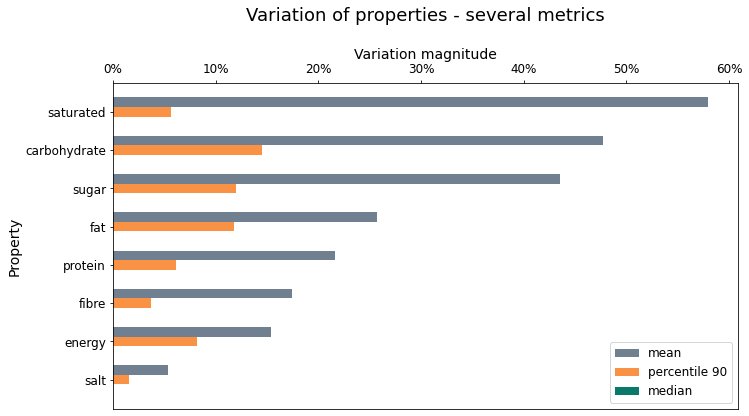

In [7]:
### Plot property variation

RESOLUTION = 0.01
RANGE = 0.5

# Prepare dataframe
df_plot_variation = df_property_variation[['matched_ingredient', 'property', 'variation']]
NROWS_DF = len(df_plot_variation)
print(f'Total observations: {NROWS_DF}')

df_plot_variation['variation_round'] = round(df_plot_variation['variation'] / RESOLUTION) * RESOLUTION

df_plot_variation_grouped = df_plot_variation[['variation_round']].groupby(['variation_round'], as_index = False).size()

NROWS_ZERO = df_plot_variation_grouped[df_plot_variation_grouped['variation_round'] == 0]['size'].sum()
NROWS_FIVE = df_plot_variation_grouped[df_plot_variation_grouped['variation_round'].between(-0.05, 0.05)]['size'].sum()

print(f'Total observations with 0% change: {NROWS_ZERO} ({NROWS_ZERO/NROWS_DF :.2%})')
print(f'Total observations with +- 5% change: {NROWS_FIVE} ({NROWS_FIVE/NROWS_DF :.2%})')

# Plot variation by property
def p_90(x):
    return x.quantile(0.9)

df_plot_variation_property = df_plot_variation[['property', 'variation']]
df_plot_variation_property = df_plot_variation_property.groupby('property', as_index = False).agg(['size', 'mean', 'median', p_90]).droplevel(0, axis = 1)

# Sort by mean and drop score
df_plot_variation_property.sort_values(by = 'mean', ascending = False, inplace = True)
df_plot_variation_property.drop(index = 'score', inplace = True)

# Drop indexes to capture property and retrieve only top 8
df_plot_variation_property.reset_index(inplace = True)
df_plot_variation_property = df_plot_variation_property.head(8)

# Plot consants
HEIGHT = 0.25

# Define figure
fig = plt.figure(1, (16 * 0.7, 6))
ax = fig.add_subplot(1, 1, 1)

# Plot mean
ax.barh(df_plot_variation_property.index - HEIGHT,
       df_plot_variation_property['mean'] * 100,
       height = HEIGHT,
       color = '#708090',
       label = 'mean')

# Plot pct 90
ax.barh(df_plot_variation_property.index,
       df_plot_variation_property['p_90'] * 100,
       height = HEIGHT,
       color = '#f99245',
       label = 'percentile 90')

# Plot median
ax.barh(df_plot_variation_property.index + HEIGHT,
       df_plot_variation_property['median'] * 100,
       height = HEIGHT,
       color = '#097969',
       label = 'median')

# Format y axis
ax.set_yticks(df_plot_variation_property.index)
ax.set_yticklabels(df_plot_variation_property['property'])
ax.tick_params(axis = 'y', which = 'both', labelsize = PLOT_SETUP['tick'])
ax.invert_yaxis()

# Format x axis
xticks = mticker.FormatStrFormatter('%.0f%%')
ax.xaxis.set_major_formatter(xticks)
ax.xaxis.set_label_position('top') 
ax.tick_params(axis = 'x', which = 'both',
               labelbottom = False, labeltop = True,
               bottom = False, top = True, labelsize = PLOT_SETUP['tick'])

# Put labels
ax.set_xlabel('Variation magnitude', fontsize = PLOT_SETUP['label'])
ax.set_ylabel('Property', fontsize = PLOT_SETUP['label'])
ax.set_title('Variation of properties - several metrics\n', fontsize = PLOT_SETUP['title'])
ax.legend(loc = 'best', fontsize = PLOT_SETUP['legend'])

plt.show()

In [8]:
### Explore saturateds

df_saturated = df_property_variation[df_property_variation['property'].isin(['saturated', 'carbohydrate'])]

# white-beans is a good example of missed data, coconut-butter and red-beans is a good example of quality gain in saturateds

df_saturated.sort_values(by = 'variation', ascending = False).head()

,matched_ingredient,property,value_75,value_80,difference,variation
3660,white-beans,saturated,0.10,22.00,21.90,219.000000
780,camembert,carbohydrate,0.01,1.50,1.49,149.000000
3654,white-beans,carbohydrate,3.20,54.00,50.80,15.875000
1089,coconut-butter,saturated,6.65,63.65,57.00,8.571429
1227,dried-horn-of-plenty-mushrooms,carbohydrate,0.40,3.00,2.60,6.500000


Scatterplot of change of property vs. row retention --> if retention is low, change may be high. Plot every ingredient as a point, maybe combine colours with properties.

In [9]:
### Calculate merged dataframe

df_75_preprocessed = df_75[['matched_ingredient', 'property_type', 'property', 'n_rows', 'reference_value']]
df_80_preprocessed = df_80[['matched_ingredient', 'property_type', 'property', 'n_rows', 'reference_value']]

df_75_preprocessed.rename(columns = {'n_rows': 'n_rows_75', 'reference_value': 'reference_value_75'}, inplace = True)
df_80_preprocessed.rename(columns = {'n_rows': 'n_rows_80', 'reference_value': 'reference_value_80'}, inplace = True)

# Filter by nutrients only and drop properties with 0 or less as reference value
df_75_preprocessed = df_75_preprocessed[df_75_preprocessed['property_type'] == 'macro_nutrient']
df_75_preprocessed = df_75_preprocessed[df_75_preprocessed['reference_value_75'] > 0]

df_80_preprocessed = df_80_preprocessed[df_80_preprocessed['property_type'] == 'macro_nutrient']
df_80_preprocessed = df_80_preprocessed[df_80_preprocessed['reference_value_80'] > 0]

df_75_preprocessed.drop(columns = 'property_type', inplace = True)
df_80_preprocessed.drop(columns = 'property_type', inplace = True)

# Merge datasets
df_log_variation = pd.merge(df_75_preprocessed,
                           df_80_preprocessed,
                           how = 'inner',
                           on = ['matched_ingredient', 'property'])

# Compute changes
df_log_variation['row_retention'] = df_log_variation['n_rows_80'] * 1.0 / df_log_variation['n_rows_75']
df_log_variation['reference_log_change'] = np.log(df_log_variation['reference_value_80'] / df_log_variation['reference_value_75'])


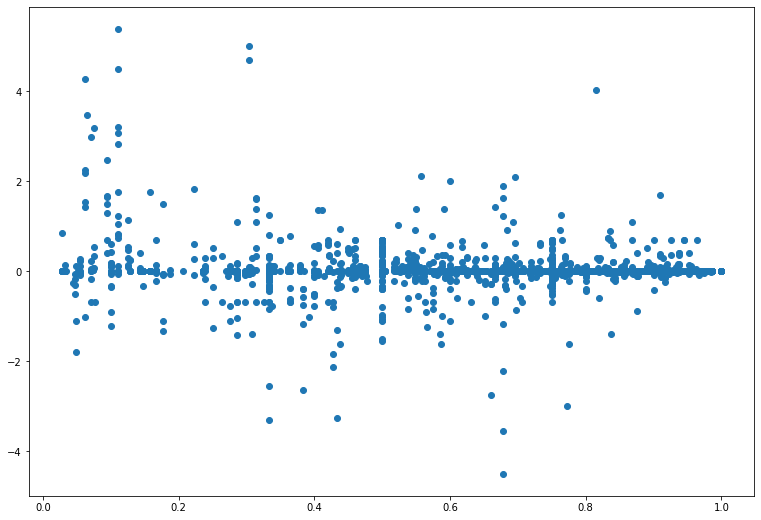

In [10]:
### Plot scatterplot

fig = plt.figure(1, (13, 9))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_log_variation['row_retention'],
          df_log_variation['reference_log_change'])


plt.show()